<a href="https://colab.research.google.com/github/Jvlia17/rodents-classification/blob/main/Rosegador.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ten kod jest poświęcony kodowaniu w ramach pracy magisterskiej skupionej na opracowywaniu niestandardowego zestawu danych do rozpoznawania gryzoni przy użyciu sztucznej inteligencji. W jego ramach wykorzystuje się najnowocześniejsze technologie, różnorodne metody bilansowania danych, dostrojenie hiperparametrów, transfer learning oraz ataki adwersarialne na sieci w celu poprawy odporności i efektywności modelu.

Github: https://github.com/Jvlia17/rodents-classification

# 0. Pobranie bibliotek

In [2]:
# Potrzebne biblioteki

import pathlib
import PIL.Image as Image
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from imblearn.over_sampling import RandomOverSampler
import random
from PIL import Image

plt.rcParams['font.size']=14

import os
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

# 1. Pobranie danych

In [2]:
# Usuwanie istniejących folderów
!rm -rf sample_data

# Pobranie danych i wyodrębnienie ich
!wget https://www.dropbox.com/scl/fi/xhgs04km1gn53ebccmjjy/Rosegador.zip?rlkey=pkbd9d125ebb4untz49lv872p&dl=0

--2024-03-03 19:47:52--  https://www.dropbox.com/scl/fi/xhgs04km1gn53ebccmjjy/Rosegador.zip?rlkey=pkbd9d125ebb4untz49lv872p
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7c4ecf03909c58132c9f1ea166.dl.dropboxusercontent.com/cd/0/inline/CObP8MzBeTj4rFq9_VMU6elNe54lqyQIHtb9ZBMzaUMNJYuqiJoUzvGUaHPlTViV4pI9DabB4-r3DKlZTffaJ-4oBPvbw4PaHJ9SD4l2VMHmYN3FWwSr6EosdmCFWker5u8VPwAlOJFC7fmT5ynzS01T/file# [following]
--2024-03-03 19:47:53--  https://uc7c4ecf03909c58132c9f1ea166.dl.dropboxusercontent.com/cd/0/inline/CObP8MzBeTj4rFq9_VMU6elNe54lqyQIHtb9ZBMzaUMNJYuqiJoUzvGUaHPlTViV4pI9DabB4-r3DKlZTffaJ-4oBPvbw4PaHJ9SD4l2VMHmYN3FWwSr6EosdmCFWker5u8VPwAlOJFC7fmT5ynzS01T/file
Resolving uc7c4ecf03909c58132c9f1ea166.dl.dropboxusercontent.com (uc7c4ecf03909c58132c9f1ea166.dl.dropboxusercontent.com)... 162.125.5.15, 2620:

In [3]:
!unzip /content/Rosegador.zip?rlkey=pkbd9d125ebb4untz49lv872p

Archive:  /content/Rosegador.zip?rlkey=pkbd9d125ebb4untz49lv872p
replace Dataset/Capybara/cap (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# 2. Sprawdzenie danych

In [4]:
# Sprawdzenie ilości obrazów w folderach

ROOT_DIR = "/content/Dataset"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

number_of_images.items()

dict_items([('Rat', 222), ('Chinchillas', 338), ('Guinea Pig', 1520), ('Capybara', 4930), ('Hamster', 1361), ('Mouse', 248)])

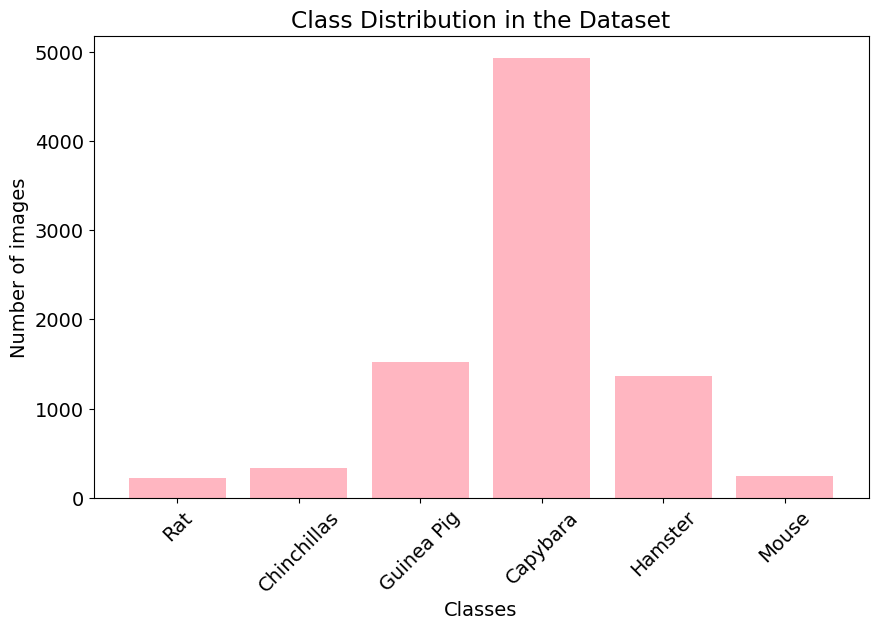

In [5]:
# Pokazanie na wykresie słupkowym rozkad liczebności klas

data_dir = '/content/Dataset'

# Zliczanie obrazów w każdej klasie
class_counts = {}
for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

# Tworzenie wykresu słupkowego
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='lightpink')
plt.xlabel('Classes')
plt.ylabel('Number of images')
plt.title('Class Distribution in the Dataset')
plt.xticks(rotation=45)
plt.show()

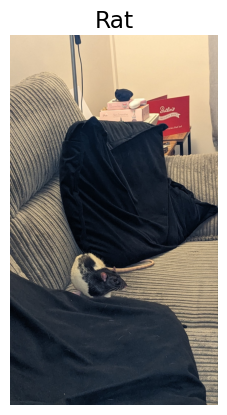

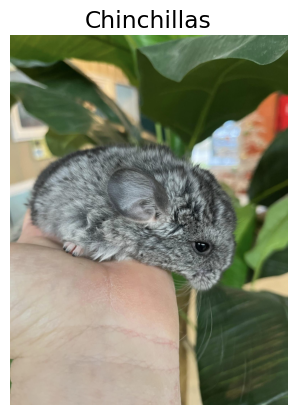

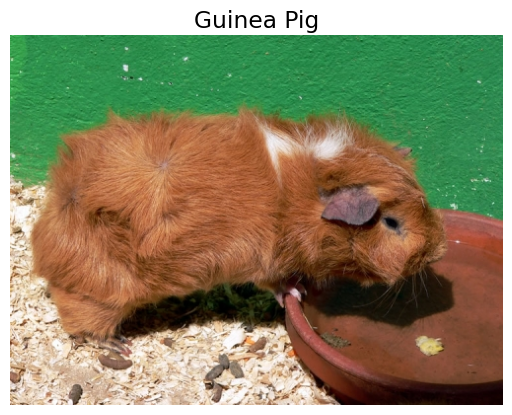

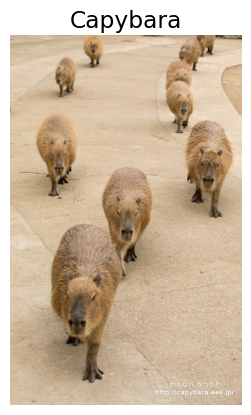

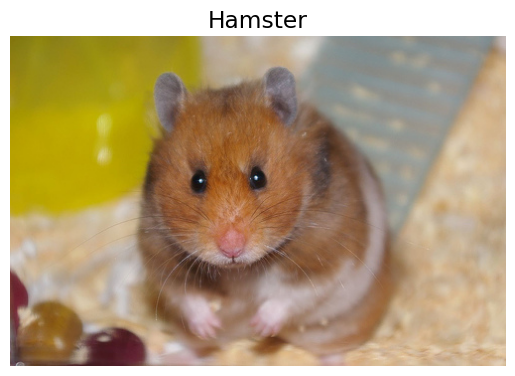

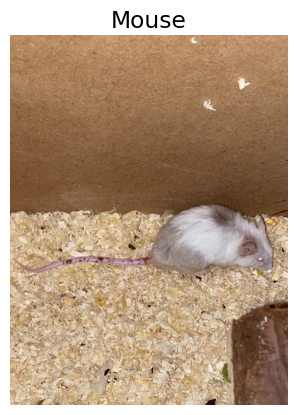

In [6]:
# Wyświetlenie randomowego obrazu z każdego folderu

data_dir = '/content/Dataset'

# Pobierz listę folderów w głównym katalogu
folders = os.listdir(data_dir)

# Iteruj po każdym folderze i wyświetl losowy obraz
for folder in folders:

    # Utwórz pełną ścieżkę do folderu
    folder_path = os.path.join(data_dir, folder)

    # Pobierz listę plików w folderze
    files = os.listdir(folder_path)

    # Wybierz losowy plik z folderu
    random_file = random.choice(files)

    # Utwórz pełną ścieżkę do losowego pliku
    file_path = os.path.join(folder_path, random_file)

    # Wczytaj obraz i wyświetl go
    image = Image.open(file_path)
    plt.imshow(image)
    plt.title(f"{folder}")
    plt.axis("off")
    plt.show()

# 3. Balansowanie klas

In [18]:
# Jest problem, że klasy muszą być wymieszane, a nie starcza RAM'u

from keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os

# Ścieżka do folderu z danymi
data_dir = '/content/Dataset'

# Funkcja do wczytywania obrazów i etykiet
def load_images_and_labels(data_dir, target_size=(224, 224)):
    images = []
    labels = []
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = load_img(img_path, target_size=target_size)
            img = img_to_array(img) # Konwertuje obraz do tablicy
            images.append(img.flatten())  # Spłaszczanie obrazu do jednowymiarowego wektora
            labels.append(class_name)
    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(data_dir)

## 3.1 RUS (Random Under-Sampling)

Polega na losowym usunięciu przykładów z klas większościowych

In [2]:
from imblearn.under_sampling import RandomUnderSampler

# Zastosowanie RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

images_resampled, labels_resampled = rus.fit_resample(images, labels)

# Przywrócenie oryginalnego kształtu obrazów
images_resampled = images_resampled.reshape((-1, 224, 224, 3))  # Przywrócenie kształtu do (wysokość, szerokość, kanały)

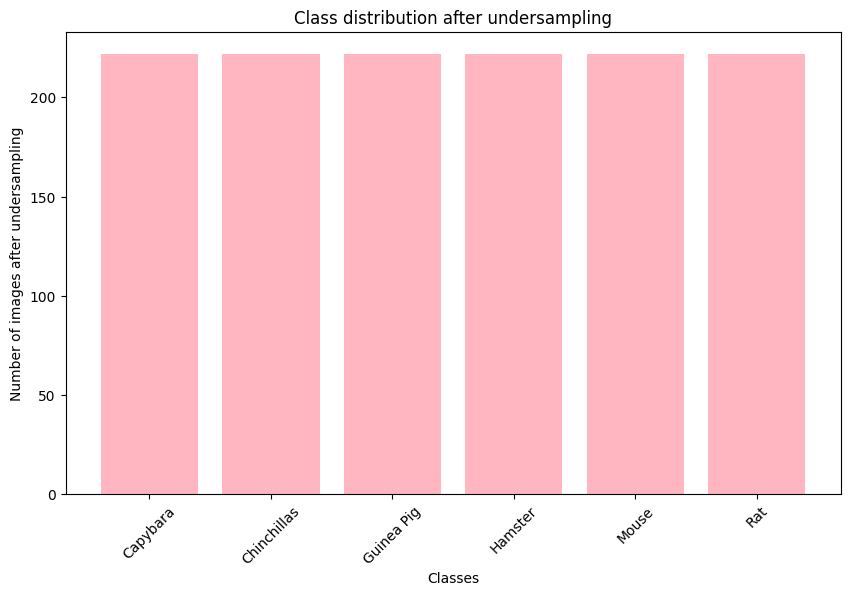

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Liczenie obrazów w każdej klasie po zastosowaniu RandomUnderSampler
unique_labels, counts = np.unique(labels_resampled, return_counts=True)
class_counts_resampled = dict(zip(unique_labels, counts))

# Tworzenie wykresu słupkowego dla zmodyfikowanych danych
plt.figure(figsize=(10, 6))
plt.bar(class_counts_resampled.keys(), class_counts_resampled.values(), color='lightpink')
plt.xlabel('Classes')
plt.ylabel('Number of images after undersampling')
plt.title('Class distribution after undersampling')
plt.xticks(rotation=45)
plt.show()

## 3.2 ROS (Random Over-Sampling)

Polega na losowym duplikowaniu przykładów z klas mniejszościowych

W przypadku OverSamplingu pojawia się problem z niewystarczającym RAM'em w środowisku Google Colab. Zostało zastosowane podejście dzielenia danych na batche, na których jest oddzielnie przeprowadzany oversampling, a następnie łączone są w całość.

In [5]:
from imblearn.over_sampling import RandomOverSampler
import numpy as np

def batch_iterator(X, y, batch_size=100):
    """Generator, który dzieli dane i etykiety na mniejsze partie."""
    for i in range(0, len(X), batch_size):
        yield X[i:i + batch_size], y[i:i + batch_size]

# Definiowanie strategii oversamplingu
oversample = RandomOverSampler(sampling_strategy='minority')

# Listy do przechowywania przetworzonych danych
images_resampled_list = []
labels_resampled_list = []

# Przetwarzanie danych w partiach
batch_size = 100  # Możesz dostosować rozmiar partii do swoich potrzeb
for images_batch, labels_batch in batch_iterator(images, labels, batch_size=batch_size):
    images_batch_resampled, labels_batch_resampled = oversample.fit_resample(images_batch, labels_batch)
    images_resampled_list.append(images_batch_resampled)
    labels_resampled_list.append(labels_batch_resampled)

# Łączenie wszystkich przetworzonych partii w jeden zbiór danych
images_resampled = np.vstack(images_resampled_list)
labels_resampled = np.concatenate(labels_resampled_list)

# Przywrócenie oryginalnego kształtu obrazów
images_resampled = images_resampled.reshape((-1, target_size[0], target_size[1], 3))

NameError: name 'images' is not defined

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Liczenie obrazów w każdej klasie po zastosowaniu RandomOverSampler
unique_labels, counts = np.unique(labels_resampled, return_counts=True)
class_counts_resampled = dict(zip(unique_labels, counts))

# Tworzenie wykresu słupkowego dla zmodyfikowanych danych
plt.figure(figsize=(10, 6))
plt.bar(class_counts_resampled.keys(), class_counts_resampled.values(), color='lightpink')
plt.xlabel('Classes')
plt.ylabel('Number of images after oversampling')
plt.title('Class distribution after oversampling')
plt.xticks(rotation=45)
plt.show()

NameError: name 'labels_resampled' is not defined

## 3.3 SMOTE (Synthetic Minority Over-sampling Technique)

Wybiera próbki z klas mniejszościowych i dla każdej z nich znajduje jej k-najbliższych sąsiadów.

Też wywala RAM.

In [ ]:
from imblearn.over_sampling import SMOTE

# Zastosowanie SMOTE
smote = SMOTE(random_state=42)

# Dla SMOTE obrazy muszą być spłaszczone
images_resampled, labels_resampled = smote.fit_resample(images, labels)

# Przywrócenie oryginalnego kształtu obrazów
target_size = (224, 224)  # Zakładając, że taki jest rozmiar obrazów
images_resampled = images_resampled.reshape((-1, target_size[0], target_size[1], 3))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Liczenie obrazów w każdej klasie po zastosowaniu RandomOverSampler
unique_labels, counts = np.unique(labels_resampled, return_counts=True)
class_counts_resampled = dict(zip(unique_labels, counts))

# Tworzenie wykresu słupkowego dla zmodyfikowanych danych
plt.figure(figsize=(10, 6))
plt.bar(class_counts_resampled.keys(), class_counts_resampled.values(), color='lightpink')
plt.xlabel('Classes')
plt.ylabel('Number of images after SMOTE')
plt.title('Class distribution after SMOTE')
plt.xticks(rotation=45)
plt.show()

# 4. Augmentacja klas

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Inicjalizacja generatora danych z augmentacją dla danych treningowych
train_datagen = ImageDataGenerator(
    rescale=1./255,   # Normalizacja wartości pikseli
    rotation_range=40,  # Losowe obracanie obrazów w zakresie (w stopniach)
    width_shift_range=0.2,  # Losowe przesunięcia poziome obrazów
    height_shift_range=0.2,  # Losowe przesunięcia pionowe obrazów
    shear_range=0.2,  # Losowe przycinanie obrazów
    zoom_range=0.2,  # Losowe przybliżanie obrazów
    horizontal_flip=True,  # Losowe odbicia lustrzane obrazów
    fill_mode='nearest'  # Strategia wypełniania nowych pikseli, które mogą powstać po augmentacji
)

# Wczytanie danych
train_generator = train_datagen.flow(
    images_resampled,
    labels_resampled,
    batch_size=32,
    target_size=(224, 224)  # Rozmiar docelowy obrazów
)

# 5. Wybranie modelu

## 5.1 VGG16

In [ ]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Zamrożenie warstw

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')  # Lub Dense(num_classes, activation='softmax') dla wielu klas
])

## 5.2 ResNet50

In [9]:
from tensorflow.keras.applications import ResNet50

# Load pre-trained ResNet50 model
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base
for layer in resnet_model.layers:
    layer.trainable = False

# Create your own classification layers
# For example, adding a GlobalAveragePooling2D layer and a Dense layer for classification
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

x = GlobalAveragePooling2D()(resnet_model.output)
output = Dense(6, activation='softmax')(x)

# Combine the base model with the custom classification layers
model = Model(resnet_model.input, output)

## 5.3 AlexNet

In [ ]:
model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(64,64,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10,activation='softmax')
])

## 5.4 EfficientNet

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

# Load pre-trained EfficientNetB0 model trained on ImageNet
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base
for layer in efficientnet_model.layers:
    layer.trainable = False

# Create your own classification layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

x = GlobalAveragePooling2D()(efficientnet_model.output)
output = Dense(6, activation='softmax')(x)

# Combine the base model with the custom classification layers
model = Model(efficientnet_model.input, output)


## 5.5 DenseNet

In [ ]:
from tensorflow.keras.applications import DenseNet121

# Load pre-trained DenseNet121 model trained on ImageNet
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base
for layer in densenet_model.layers:
    layer.trainable = False

# Create your own classification layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

x = GlobalAveragePooling2D()(densenet_model.output)
output = Dense(6, activation='softmax')(x)

# Combine the base model with the custom classification layers
model = Model(densenet_model.input, output)


## 5.6 MobileNet

In [ ]:
from tensorflow.keras.applications import MobileNet

# Load pre-trained MobileNet model trained on ImageNet
mobilenet_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional base
for layer in mobilenet_model.layers:
    layer.trainable = False

# Create your own classification layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

x = GlobalAveragePooling2D()(mobilenet_model.output)
output = Dense(6, activation='softmax')(x)

# Combine the base model with the custom classification layers
model = Model(mobilenet_model.input, output)


# 6. Trenowanie modelu

In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Trening modelu
model.fit(train_generator, epochs=10)  # Liczba epok do dostosowania

  9/270 [>.............................] - ETA: 28:47 - loss: 0.3199 - accuracy: 0.6215

KeyboardInterrupt: 

# 7. Ewaluacja modelu

## 7.1 Training vs validation accuracy/loss

In [ ]:
# yeah

## 7.2 Confusion matrix

In [ ]:
# yeah

# 8. Ataki adwersarzowe

In [ ]:
# yeah

# 9. Out of Distribution (OOD) Detection

In [ ]:
# yeah